# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [27]:
%matplotlib inline

import os
import sys 
import json
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from datetime import date
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.utils.timez import epochptime

In [28]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures")
# RESULTS  = os.path.join(FIXTURES, 'test-raft-single.json')
RESULTS  = os.path.join(FIXTURES, 'test-eventual-single.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

In [29]:
def title(text):
    return " ".join([t.capitalize() for t in text.split("_")])

def report(data, title=None, total=None, sort=True):
    """
    Expects data to be a list of (name, value) pairs.
    Total will be computed from data or accepted if passed in.
    Title will be the header for the report. 
    """
    if total is None:
        total = sum(val[1] for val in data)
    
    if title is None:
        title = "Key/Val Report"
    
    if sort:
        data = sorted(data, key=itemgetter(0))
    
    # Banner length and max key length
    blen = len(title)
    klen = max([max([len(val[0]) for val in data]), len('total')])
    fmtr = "{{: <{}}} {{: >{}}}".format(klen, blen-klen-1)
    
    output = [title, "="*blen]
    
    for key, val in data:
        output.append(fmtr.format(key, val))
                
    output.append("-"*blen)
    output.append(fmtr.format('total', total))
    return "\n".join(output)

def report_details():
    banner = (
        "Simulation: {} (Cloudscope v{})\n"
        "{}\n\n"
        "Ran on: {} ({})\n\n"
        "Settings\n"
        "========\n"
    ).format(
        data['simulation'], data['version'], data['topology']['meta']['description'],
        epochptime(data['timer']['started']).strftime('%b %d, %Y at %H:%M %Z'), 
        data['timer']['elapsed'],
        data['randseed'],
    )
    
    longest = max(len(key) for key in data['settings'])
    frmt = "{{: <{0}}} {{: >12}}".format(longest)
    
    
    return banner + "\n".join([
        frmt.format(title(key), value)
        for key, value in data['settings'].items()
    ])
    

def report_topology():
    topology = deepcopy(data['topology'])
    nodes = topology['nodes']
    links = topology['links']
    
    for link in links:
        latency = [link['latency']] if link['connection'] == 'constant' else link['latency']
        
        for rid in ('source', 'target'):
            node = nodes[link[rid]]
            
            if 'minlat' not in node:
                node['minlat'] = latency[0]
            else:
                
                node['minlat'] = min(node['minlat'], latency[0])

            if 'maxlat' not in node:
                node['maxlat'] = latency[-1]
            else:
                node['maxlat'] = max(node['maxlat'], latency[-1])
         
    output = []
    for node in sorted(nodes, key=itemgetter('id')):
        output.append(
            "{}: {} ({}, {}) {}-{}ms connection".format(
                node['id'], node['label'], node['location'], node['consistency'], node['minlat'], node['maxlat']
            )
        )
    return "\n".join(output)

In [30]:
def report_reads_writes():
    counts = defaultdict(Counter)
    totals = Counter()
    for access in ('read', 'write'):
        for (rid, loc, ts) in data['results'].get(access, []):
            counts[rid][access] += 1
            totals[access] += 1
    
    total = "{}/{}".format(totals['read'], totals['write'])
    
    return report([
            (rid, "{}/{}".format(c['read'], c['write']))
            for rid, c in counts.items()
        ], "Accesses (read/write)", total=total)

In [31]:
def report_stale_reads():
    stale = data['results'].get('stale reads', [])
    if not stale:
        return "No Stale Reads"
    
    stale.sort(key=itemgetter(0))
    
    return report([
            (rid, sum(1 for v in values))
            for rid, values in groupby(stale, itemgetter(0))
        ], "Stale Reads")

In [32]:
def report_visibility_latencies():
    visibilities = data['results'].get('visibility latency', [])
    if not visibilities:
        return "No visibility latency metrics" 
    
    latencies = defaultdict(list)
    versions  = set([])
    
    for writer, vid, start, finish in visibilities:
        latencies[writer].append(finish - start)
        versions.add(vid)
    
    total  = sum(l for l in chain(*latencies.values())) / sum(1 for l in chain(*latencies.values()))
    total  = "{:0.4f} secs".format(total / 1000)

    header =  (
        "Fully visible writes:{: >6}\n"
        "Total number of writes:{: >4}\n\n"
    ).format(len(versions), len(data['results']['write']))
    
    return header + report([
        (rid, "{:0.4f} secs".format((sum(l) / len(l)) / 1000))
        for rid, l in latencies.items()
    ], 'Mean Visibility Latency', total=total)

In [33]:
def draw_topology():
    cmap = {
        'strong': '#91cf60',
        'medium': '#ffffbf',
        'low': '#fc8d59',
    }
    
    lmap = {
        'constant': 'solid',
        'variable': 'dashed',
    }

    G = json_graph.node_link_graph(data['topology'])
    colors = [cmap[n[1]['consistency']] for n in G.nodes(data=True)]
    links  = [lmap[n[2]['connection']] for n in G.edges(data=True)]
    nx.draw_circular(G, with_labels=True, node_size=800, node_color=colors, font_weight='bold', style=links, edge_color='#333333')

# Results 

In [34]:
print report_details()

Simulation: Eventually There (Cloudscope v0.2)
Single Consistency Type: An Eventually Consistent Data Center.

Ran on: Feb 19, 2016 at 17:25 UTC (7 seconds)

Settings
Default Latency              800
Do Rumoring                    1
Users                          1
Move Prob                    0.2
Anti Entropy Delay           600
Election Timeout      [150, 300]
Valid Locations     [u'home', u'work', u'mobile', u'cloud']
Switch Prob                  0.3
Heartbeat Interval            75
Access Stddev                512
Default Replica          storage
Default Consistency       strong
Random Seed                   42
Invalid Types        [u'backup']
Read Prob                   0.68
Do Gossip                      1
Max Sim Time             4320000
Access Mean                 1800


## Topology

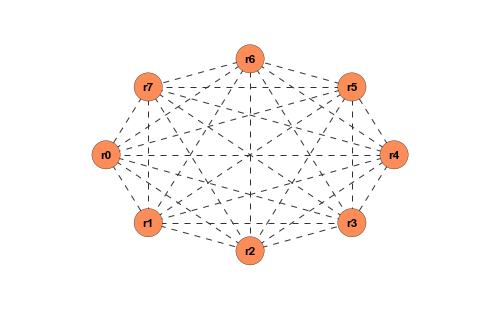

In [35]:
draw_topology()

In [36]:
print report_topology()

r0: Eventual 1 (cloud, low) 300-1500ms connection
r1: Eventual 2 (cloud, low) 300-1500ms connection
r2: Eventual 3 (cloud, low) 300-1500ms connection
r3: Eventual 4 (cloud, low) 300-1500ms connection
r4: Eventual 5 (cloud, low) 300-1500ms connection
r5: Eventual 6 (cloud, low) 300-1500ms connection
r6: Eventual 7 (cloud, low) 300-1500ms connection
r7: Eventual 8 (cloud, low) 300-1500ms connection


## Metrics 

The following metrics are reported from the results.

### Reads and Writes

In [37]:
print report_reads_writes()

Accesses (read/write)
r0             181/92
r1            173/101
r2             187/82
r3             194/91
r4             205/99
r5            228/119
r6            207/105
r7            239/120
---------------------
total        1614/809


### Stale Reads

In [38]:
print report_stale_reads()

Stale Reads
r0       28
r1       25
r2       41
r3       37
r4       40
r5       45
r6       49
r7       50
-----------
total   315


### Visibility Latency 

In [39]:
print report_visibility_latencies()

Fully visible writes:   715
Total number of writes: 809

Mean Visibility Latency
r0          3.1258 secs
r1          3.2135 secs
r2          3.1268 secs
r3          3.1797 secs
r4          3.2626 secs
r5          3.1837 secs
r6          3.2388 secs
r7          3.2503 secs
-----------------------
total       3.2028 secs
